# Classifying newswires: a multi-class classification example

In the previous video we saw how to classify vector inputs into two mutually exclusive classes using a densely-connected neural network. 


But what happens when you have more than two classes? 

In this video, we will build a network to classify Reuters newswires into 46 different mutually-exclusive topics. 

## The Reuters dataset


We will be working with the _Reuters dataset_, a set of short newswires and their topics, published by Reuters in 1986.

Like IMDB and MNIST, the Reuters dataset comes packaged as part of Keras. Let's take a look right away:

In [1]:
from tensorflow import keras
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

In [2]:
import tensorflow as tf
tf.__version__

'2.0.0-beta0'


Like with the IMDB dataset, the argument `num_words=10000` restricts the data to the 10,000 most frequently occurring words found in the 
data.

We have 8,982 training examples and 2,246 test examples:

In [3]:
len(train_data)

8982

In [4]:
len(test_data)

2246

As with the IMDB reviews, each example is a list of integers (word indices):

In [7]:
print(train_data[10])

[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]


Here's how you can decode it back to words, in case you are curious:

In [8]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [9]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

The label associated with an example is an integer between 0 and 45: a topic index.

In [10]:
train_labels[10]

3

## Preparing the data

We can vectorize the data with the exact same code as in our previous example:

In [11]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)


To vectorize the labels, there are two possibilities: we could just cast the label list as an integer tensor, or we could use a "one-hot" encoding. 

One-hot encoding is a widely used format for categorical data, also called "categorical encoding". 

Note that there is a built-in way to do this in Keras

In [12]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

Using TensorFlow backend.


## Building our network


In [13]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

We are ending the network with a `Dense` layer of size 46. 

This means that for each input sample, our network will output a 46-dimensional vector. 

Each entry in this vector (each dimension) will encode a different output class.


In [14]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Validating our approach

Let's set apart 1,000 samples in our training data to use as a validation set:

In [15]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Now let's train our network for 10 epochs:

In [16]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 2s 267us/sample - loss: 2.5931 - accuracy: 0.5510 - val_loss: 1.6887 - val_accuracy: 0.6570
Epoch 2/10
7982/7982 [==============================] - 1s 166us/sample - loss: 1.3786 - accuracy: 0.7179 - val_loss: 1.2672 - val_accuracy: 0.7280
Epoch 3/10
7982/7982 [==============================] - 1s 168us/sample - loss: 1.0071 - accuracy: 0.7885 - val_loss: 1.1052 - val_accuracy: 0.7630
Epoch 4/10
7982/7982 [==============================] - 1s 163us/sample - loss: 0.7874 - accuracy: 0.8385 - val_loss: 1.0230 - val_accuracy: 0.7780
Epoch 5/10
7982/7982 [==============================] - 1s 164us/sample - loss: 0.6268 - accuracy: 0.8710 - val_loss: 0.9599 - val_accuracy: 0.7840
Epoch 6/10
7982/7982 [==============================] - 1s 181us/sample - loss: 0.5039 - accuracy: 0.8960 - val_loss: 0.9170 - val_accuracy: 0.8020
Epoch 7/10
7982/7982 [==============================] - 1s 180us

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Let's display its loss and accuracy curves:

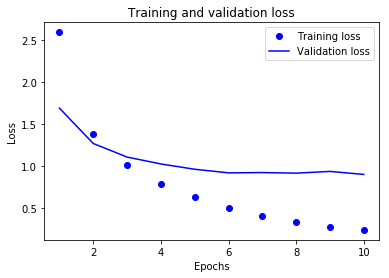

In [19]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

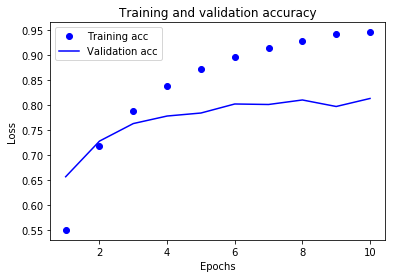

In [20]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Generating predictions on new data

We can verify that the `predict` method of our model instance returns a probability distribution over all 46 topics. 

Let's generate topic predictions for all of the test data:

In [21]:
predictions = model.predict(x_test)

Each entry in `predictions` is a vector of length 46:

In [22]:
predictions[0].shape

(46,)

The coefficients in this vector sum to 1:

In [23]:
np.sum(predictions[0])

1.0

The largest entry is the predicted class, i.e. the class with the highest probability:

In [24]:
np.argmax(predictions[0])

3

## Wrapping up


Here's what you should take away from this example:

* If you are trying to classify data points between N classes, your network should end with a `Dense` layer of size N.


* In a single-label, multi-class classification problem, your network should end with a `softmax` activation, so that it will output a probability distribution over the N output classes.


* _Categorical crossentropy_ is almost always the loss function you should use for such problems. 